# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, LeakyReLU, ReLU
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# combining files

In [3]:
# Load the datasets
dataset1 = pd.read_csv('/content/drive/MyDrive/IMD-TP Load Forecast/Yearly Data/2018.csv').values
dataset2 = pd.read_csv('/content/drive/MyDrive/IMD-TP Load Forecast/Yearly Data/2019.csv').values
dataset3 = pd.read_csv('/content/drive/MyDrive/IMD-TP Load Forecast/Yearly Data/2020.csv').values
dataset4 = pd.read_csv('/content/drive/MyDrive/IMD-TP Load Forecast/Yearly Data/2021.csv').values


In [6]:
dataset1

array([['01-01-2018 00:00', 80.423, 18.16, 174.542804],
       ['01-01-2018 00:15', 81.471, 18.064, 175.981604],
       ['01-01-2018 00:30', 82.675, 17.927, 178.636804],
       ...,
       ['31-12-2018 23:15', 61.66634545, 17.689, 181.6006],
       ['31-12-2018 23:30', 60.73270909, 17.818, 183.150424],
       ['31-12-2018 23:45', 60.94089091, 17.827, 183.731516]],
      dtype=object)

In [ ]:
# Combine the datasets into a single array
combined_data = np.concatenate((dataset1, dataset2, dataset3, dataset4), axis=0)

# Save the combined data as an npy file
np.save('/content/drive/MyDrive/IMD-TP Load Forecast/Yearly Data/combined_data.npy', combined_data)

# Checking missing rows

In [ ]:
import pandas as pd

# Read the data from the CSV file
data_r = pd.read_csv('/content/drive/MyDrive/IMD-TP Load Forecast/Yearly Data/2021.csv')

# Convert 'DateTime' column to datetime format
data_r['DateTime'] = pd.to_datetime(data_r['DateTime'], format='%d-%m-%Y %H:%M')

# Set 'DateTime' as the index
data_r.set_index('DateTime', inplace=True)

# Define the expected frequency (15 minutes)
expected_freq = pd.Timedelta(minutes=15)

# Generate the expected datetime range
expected_range = pd.date_range(start=data_r.index.min(), end=data_r.index.max(), freq=expected_freq)

# Find the missing rows
missing_rows = expected_range[~expected_range.isin(data_r.index)]

# Print the missing rows
print("Missing rows:")
for row in missing_rows:
    print(row)

Streaming output truncated to the last 5000 lines.
2021-02-01 16:30:00
2021-02-01 16:45:00
2021-02-01 17:00:00
2021-02-01 17:15:00
2021-02-01 17:30:00
2021-02-01 17:45:00
2021-02-01 18:00:00
2021-02-01 18:15:00
2021-02-03 18:30:00
2021-02-03 18:45:00
2021-02-03 19:00:00
2021-02-03 19:15:00
2021-02-03 19:30:00
2021-02-03 19:45:00
2021-02-03 20:00:00
2021-02-03 20:15:00
2021-02-03 20:30:00
2021-02-03 20:45:00
2021-02-03 21:00:00
2021-02-03 21:15:00
2021-02-03 21:30:00
2021-02-03 21:45:00
2021-02-03 22:00:00
2021-02-03 22:15:00
2021-02-03 22:30:00
2021-02-03 22:45:00
2021-02-03 23:00:00
2021-02-03 23:15:00
2021-02-03 23:30:00
2021-02-03 23:45:00
2021-02-04 00:00:00
2021-02-04 00:15:00
2021-02-04 00:30:00
2021-02-04 00:45:00
2021-02-04 01:00:00
2021-02-04 01:15:00
2021-02-04 01:30:00
2021-02-04 01:45:00
2021-02-04 02:00:00
2021-02-04 02:15:00
2021-02-04 02:30:00
2021-02-04 02:45:00
2021-02-04 03:00:00
2021-02-04 03:15:00
2021-02-04 03:30:00
2021-02-04 03:45:00
2021-02-04 04:00:00
2021-02-0

# Preprocessing

In [7]:
data = np.load('/content/drive/MyDrive/IMD-TP Load Forecast/Yearly Data/combined_data.npy', allow_pickle=True)

In [8]:
data.shape

(134496, 4)

In [9]:
data

array([['01-01-2018 00:00', 80.423, 18.16, 174.542804],
       ['01-01-2018 00:15', 81.471, 18.064, 175.981604],
       ['01-01-2018 00:30', 82.675, 17.927, 178.636804],
       ...,
       ['31-12-2021 23:15', 67.06, 23.96, 191.251176],
       ['31-12-2021 23:30', 68.02, 23.82, 191.744868],
       ['31-12-2021 23:45', 68.78, 23.72, 191.975328]], dtype=object)

In [ ]:
# data = np.delete(data, 0, axis=1)
# # data = np.delete(data, 1, axis=1)
# # data = np.delete(data, 3, axis=1)

In [10]:
columns_to_delete = [0,2,3]
data = np.delete(data, columns_to_delete, axis=1)

In [13]:
data = data.astype(np.float32)
data
np.save('/content/drive/MyDrive/IMD-TP Load Forecast/Yearly Data/combined_RH_data.npy', data)

In [14]:
RH_data = np.load('/content/drive/MyDrive/IMD-TP Load Forecast/Yearly Data/combined_RH_data.npy', allow_pickle=True)
# RH_data = np.load('/content/combined_RH_data.npy', allow_pickle=True)

In [15]:
RH_data.shape

(134496, 1)

In [16]:
RH_data

array([[80.423],
       [81.471],
       [82.675],
       ...,
       [67.06 ],
       [68.02 ],
       [68.78 ]], dtype=float32)

# LSTM Model creation

In [ ]:
RH_data = np.load('/content/drive/MyDrive/IMD-TP Load Forecast/Yearly Data/combined_RH_data.npy', allow_pickle=True)

In [ ]:
RH_data.shape
RH_data

In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
humidity_scaled = scaler.fit_transform(RH_data)

# Prepare the dataset for LSTM
n_steps = 96  # Number of time steps per sample
X, y = [], []
for i in range(672, len(humidity_scaled) - n_steps):
    X.append(humidity_scaled[i-672:i])
    y.append(humidity_scaled[i:i+96])
X, y = np.array(X), np.array(y)


# # Split the dataset into training and testing sets
# train_size = int(0.8 * len(X))
# X_train, X_test = X[:train_size], X[train_size:]
# y_train, y_test = y[:train_size], y[train_size:]
y=y.reshape(X.shape[0],y.shape[1]*y.shape[2])
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.25,shuffle=False)


In [ ]:
humidity_scaled.shape


(134496, 1)

In [ ]:
len(humidity_scaled)

134496

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(100296, 672, 1)
(33432, 672, 1)
(100296, 96)
(33432, 96)


In [17]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.activations import relu

In [18]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(RH_data)

In [19]:
scaled_data

array([[0.80423   ],
       [0.81470996],
       [0.82675004],
       ...,
       [0.67059994],
       [0.6802    ],
       [0.6878    ]], dtype=float32)

In [20]:
# Preprocess the data
n_steps_in = 96 * 7  # Number of steps to take as input
n_steps_out = 96  # Number of steps to predict


# Reshape the data into input and target sequences
X, y = [], []
for i in range(n_steps_in, len(scaled_data) - n_steps_out + 1):
    X.append(scaled_data[i - n_steps_in:i])
    y.append(scaled_data[i:i + n_steps_out, 0])  # Extract the first column of the target data

X = np.array(X)
y = np.array(y)


# # Build the LSTM model
# model = Sequential()
# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(n_steps_in, 1)))
# model.add(LSTM(32, return_sequences=True, activation='relu'))
# model.add(Dense(n_steps_out))



In [23]:
# Split the data into training and testing sets

# y=y.reshape(X.shape[0],y.shape[1]*y.shape[2])
# X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.25,shuffle=False)


split_index = int(0.75 * len(X))  # 80% for training, 20% for testing
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [24]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(100296, 672, 1)
(33433, 672, 1)
(100296, 96)
(33433, 96)


In [25]:
model = Sequential()
model.add(LSTM(164, return_sequences=True, activation=ReLU(), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(219, return_sequences=True, activation=ReLU()))
model.add(LSTM(69, return_sequences=False, activation=ReLU()))
model.add(Dense(y_train.shape[1], activation='tanh'))
model.compile(optimizer='RMSprop',loss='mse',metrics=['mse'])
model.summary()

# # Compile the model
# model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=2, batch_size=32, validation_split=0.1,verbose=1)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 672, 164)          108896    
                                                                 
 lstm_1 (LSTM)               (None, 672, 219)          336384    
                                                                 
 lstm_2 (LSTM)               (None, 69)                79764     
                                                                 
 dense (Dense)               (None, 96)                6720      
                                                                 
Total params: 531,764
Trainable params: 531,764
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
 130/2508 [>.............................] - ETA: 2:52:49 - loss: nan - mse: nan

KeyboardInterrupt: ignored

In [ ]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test loss:", loss)

KeyError: ignored

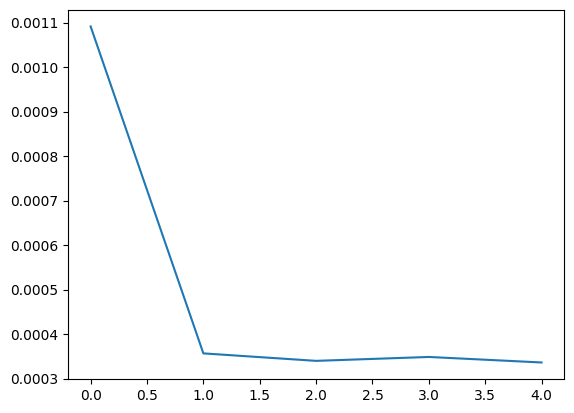

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

# smthg

In [ ]:
# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
y_test_scaled = scaler.transform(np.array(y_test).reshape(-1, 1))

In [ ]:
X_test

array([[81.66789474, 28.12210526],
       [91.24, 28.72],
       [51.53, 29.77],
       ...,
       [55.745, 33.216],
       [67.17, 26.93],
       [71.445, 22.885]], dtype=object)

# multi-output model

In [ ]:
# Build the multi-output model
input_layer = Input(shape=(2,))
hidden_layer = Dense(64, activation='relu')(input_layer)
output1 = Dense(1, name='output1')(hidden_layer)  # Temperature prediction
output2 = Dense(1, name='output2')(hidden_layer)  # Humidity prediction
output3 = Dense(1, name='output3')(hidden_layer)  # Load prediction

model = Model(inputs=input_layer, outputs=[output1, output2, output3])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_scaled, [y_train_scaled, y_train_scaled, y_train_scaled],
          validation_data=(X_test_scaled, [y_test_scaled, y_test_scaled, y_test_scaled]),
          epochs=5, batch_size=32)

# # Predict on test data
# predictions = model.predict(X_test_scaled)

# # Rescale the predictions back to the original scale
# predictions_rescaled = [scaler.inverse_transform(pred.reshape(-1, 1)).flatten() for pred in predictions]

# # Print the predicted values
# for i, pred in enumerate(predictions_rescaled):
#     print(f"Prediction for sample {i+1}: Temperature={pred[0]}, Humidity={pred[1]}, Load={pred[2]}")


Epoch 1/5
3153/3153 [==============================] - 13s 4ms/step - loss: 0.0653 - output1_loss: 0.0221 - output2_loss: 0.0210 - output3_loss: 0.0223 - val_loss: 0.0583 - val_output1_loss: 0.0195 - val_output2_loss: 0.0195 - val_output3_loss: 0.0194
Epoch 2/5
3153/3153 [==============================] - 13s 4ms/step - loss: 0.0571 - output1_loss: 0.0191 - output2_loss: 0.0190 - output3_loss: 0.0191 - val_loss: 0.0576 - val_output1_loss: 0.0192 - val_output2_loss: 0.0192 - val_output3_loss: 0.0192
Epoch 3/5
3153/3153 [==============================] - 9s 3ms/step - loss: 0.0570 - output1_loss: 0.0190 - output2_loss: 0.0190 - output3_loss: 0.0190 - val_loss: 0.0567 - val_output1_loss: 0.0189 - val_output2_loss: 0.0189 - val_output3_loss: 0.0189
Epoch 4/5
3153/3153 [==============================] - 12s 4ms/step - loss: 0.0566 - output1_loss: 0.0189 - output2_loss: 0.0189 - output3_loss: 0.0189 - val_loss: 0.0560 - val_output1_loss: 0.0186 - val_output2_loss: 0.0186 - val_output3_loss: 

In [ ]:
# Evaluate the performance of the DNN model
mse = model.evaluate(X_test_scaled, y_test_scaled)
print("Mean Squared Error:", mse)

1051/1051 [==============================] - 2s 2ms/step - loss: 0.0560 - output1_loss: 0.0187 - output2_loss: 0.0188 - output3_loss: 0.0186
Mean Squared Error: [0.05604485794901848, 0.018656382337212563, 0.01875092089176178, 0.018637558445334435]


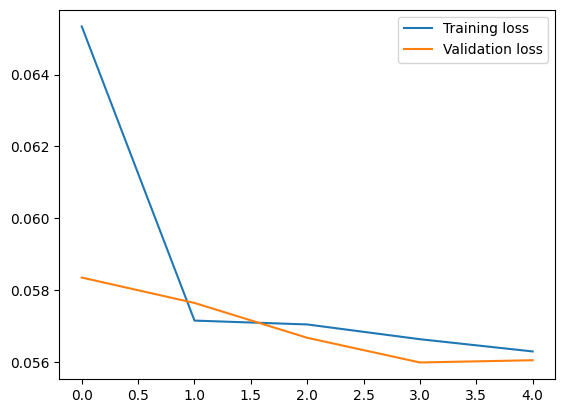

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
X_train_scaled.shape

(23424, 2)

# ANN

# ANN optuna

In [39]:
%pip install optuna
import optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.8 MB/s eta 0:00:00


In [40]:
def create_model(trial):

  # Create the ANN model
  model = Sequential()
  model.add(Dense(units=(trial.suggest_int('ann_1_units',y_train.shape[1], X_train.shape[1])), activation='relu', input_dim=X_train.shape[1]))
  model.add(Dense(units=(trial.suggest_int('ann_2_units',y_train.shape[1], X_train.shape[1])),activation="relu"))
  # ann.add(tf.keras.layers.Dense(units=(trial.suggest_int('ann_2_units',y_train.shape[1], X_train.shape[1])),activation="relu"))
  model.add(tf.keras.layers.Dense(y_train.shape[1]))

  # Compile the model
  optimizer_name = trial.suggest_categorical("optimizer", ["adam", "SGD", "RMSprop", "Adadelta"])
  # optimizer = tf.keras.optimizers.Adam(learning_rate=trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True))
  # model.compile(optimizer=optimizer_name, loss='mse', metrics=['mse'])
  model.compile(optimizer=optimizer_name, loss="binary_crossentropy",metrics=['accuracy'])

  return model

def objective(trial):
    model = create_model(trial)
    epochs = trial.suggest_int("epochs", 5, 50,step=5, log=False)
    batchsize = trial.suggest_int("batchsize", 5, 50,step=5, log=False)

    # Train the model
    model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs)

    # Evaluate the model
    scores = model.evaluate(X_test, y_test, verbose=0)
    return scores[1]

study = optuna.create_study()
study.optimize(objective, n_trials=5)

print(study.best_params)

[I 2023-07-11 16:41:32,294] A new study created in memory with name: no-name-d69cb06d-4c53-41b2-898c-64ad4107adcc


Epoch 1/5
2006/2006 [==============================] - 10s 4ms/step - loss: 5.4786 - accuracy: 0.0125
Epoch 2/5
2006/2006 [==============================] - 7s 3ms/step - loss: 4.4798 - accuracy: 0.0131
Epoch 3/5
2006/2006 [==============================] - 8s 4ms/step - loss: 3.9505 - accuracy: 0.0136
Epoch 4/5
2006/2006 [==============================] - 7s 4ms/step - loss: 3.5150 - accuracy: 0.0106
Epoch 5/5
2006/2006 [==============================] - 9s 5ms/step - loss: 3.3081 - accuracy: 0.0136


[I 2023-07-11 16:42:16,932] Trial 0 finished with value: 0.012592349201440811 and parameters: {'ann_1_units': 205, 'ann_2_units': 355, 'optimizer': 'Adadelta', 'epochs': 5, 'batchsize': 50}. Best is trial 0 with value: 0.012592349201440811.


Epoch 1/40
4012/4012 [==============================] - 19s 4ms/step - loss: 5.5188 - accuracy: 0.0114
Epoch 2/40
4012/4012 [==============================] - 23s 6ms/step - loss: 4.1236 - accuracy: 0.0134
Epoch 3/40
4012/4012 [==============================] - 24s 6ms/step - loss: 3.6275 - accuracy: 0.0133
Epoch 4/40
4012/4012 [==============================] - 20s 5ms/step - loss: 3.3317 - accuracy: 0.0132
Epoch 5/40
4012/4012 [==============================] - 15s 4ms/step - loss: 3.3092 - accuracy: 0.0152
Epoch 6/40
4012/4012 [==============================] - 15s 4ms/step - loss: 3.3073 - accuracy: 0.0164
Epoch 7/40
4012/4012 [==============================] - 15s 4ms/step - loss: 3.2825 - accuracy: 0.0167
Epoch 8/40
4012/4012 [==============================] - 16s 4ms/step - loss: 3.0624 - accuracy: 0.0157
Epoch 9/40
4012/4012 [==============================] - 15s 4ms/step - loss: 2.9456 - accuracy: 0.0163
Epoch 10/40
4012/4012 [==============================] - 15s 4ms/step - l

[I 2023-07-11 16:53:42,865] Trial 1 finished with value: 0.022313283756375313 and parameters: {'ann_1_units': 114, 'ann_2_units': 638, 'optimizer': 'Adadelta', 'epochs': 40, 'batchsize': 25}. Best is trial 0 with value: 0.012592349201440811.


Epoch 1/25
6687/6687 [==============================] - 27s 4ms/step - loss: 1.8171 - accuracy: 0.0241
Epoch 2/25
6687/6687 [==============================] - 27s 4ms/step - loss: 0.7766 - accuracy: 0.0306
Epoch 3/25
6687/6687 [==============================] - 25s 4ms/step - loss: 0.6578 - accuracy: 0.0345
Epoch 4/25
6687/6687 [==============================] - 25s 4ms/step - loss: 0.6568 - accuracy: 0.0362
Epoch 5/25
6687/6687 [==============================] - 25s 4ms/step - loss: 0.6561 - accuracy: 0.0377
Epoch 6/25
6687/6687 [==============================] - 26s 4ms/step - loss: 0.6271 - accuracy: 0.0362
Epoch 7/25
6687/6687 [==============================] - 26s 4ms/step - loss: 0.5451 - accuracy: 0.0374
Epoch 8/25
6687/6687 [==============================] - 25s 4ms/step - loss: 0.5448 - accuracy: 0.0372
Epoch 9/25
6687/6687 [==============================] - 25s 4ms/step - loss: 0.5446 - accuracy: 0.0386
Epoch 10/25
6687/6687 [==============================] - 24s 4ms/step - l

[I 2023-07-11 17:05:08,743] Trial 2 finished with value: 0.05007028952240944 and parameters: {'ann_1_units': 338, 'ann_2_units': 414, 'optimizer': 'RMSprop', 'epochs': 25, 'batchsize': 15}. Best is trial 0 with value: 0.012592349201440811.


Epoch 1/35
6687/6687 [==============================] - 28s 4ms/step - loss: 1.2374 - accuracy: 0.0161
Epoch 2/35
6687/6687 [==============================] - 26s 4ms/step - loss: 0.7743 - accuracy: 0.0173
Epoch 3/35
6687/6687 [==============================] - 26s 4ms/step - loss: 0.7792 - accuracy: 0.0134
Epoch 4/35
6687/6687 [==============================] - 26s 4ms/step - loss: 0.7784 - accuracy: 0.0136
Epoch 5/35
6687/6687 [==============================] - 26s 4ms/step - loss: 0.7784 - accuracy: 0.0138
Epoch 6/35
6687/6687 [==============================] - 25s 4ms/step - loss: 0.7782 - accuracy: 0.0155
Epoch 7/35
6687/6687 [==============================] - 26s 4ms/step - loss: 0.7781 - accuracy: 0.0156
Epoch 8/35
6687/6687 [==============================] - 26s 4ms/step - loss: 0.7781 - accuracy: 0.0163
Epoch 9/35
6687/6687 [==============================] - 26s 4ms/step - loss: 0.7780 - accuracy: 0.0175
Epoch 10/35
6687/6687 [==============================] - 26s 4ms/step - l

[I 2023-07-11 17:20:34,891] Trial 3 finished with value: 0.016690095886588097 and parameters: {'ann_1_units': 483, 'ann_2_units': 150, 'optimizer': 'adam', 'epochs': 35, 'batchsize': 15}. Best is trial 0 with value: 0.012592349201440811.


Epoch 1/45
3344/3344 [==============================] - 16s 4ms/step - loss: 7.1134 - accuracy: 0.0098
Epoch 2/45
3344/3344 [==============================] - 13s 4ms/step - loss: 7.1168 - accuracy: 0.0098
Epoch 3/45
3344/3344 [==============================] - 13s 4ms/step - loss: 7.1167 - accuracy: 0.0098
Epoch 4/45
3344/3344 [==============================] - 13s 4ms/step - loss: 7.1167 - accuracy: 0.0098
Epoch 5/45
3344/3344 [==============================] - 13s 4ms/step - loss: 7.1167 - accuracy: 0.0098
Epoch 6/45
3344/3344 [==============================] - 14s 4ms/step - loss: 7.1167 - accuracy: 0.0098
Epoch 7/45
3344/3344 [==============================] - 14s 4ms/step - loss: 7.1167 - accuracy: 0.0098
Epoch 8/45
3344/3344 [==============================] - 13s 4ms/step - loss: 7.1167 - accuracy: 0.0098
Epoch 9/45
3344/3344 [==============================] - 16s 5ms/step - loss: 7.1168 - accuracy: 0.0098
Epoch 10/45
3344/3344 [==============================] - 14s 4ms/step - l

[I 2023-07-11 17:30:41,571] Trial 4 finished with value: 0.009661112911999226 and parameters: {'ann_1_units': 363, 'ann_2_units': 623, 'optimizer': 'RMSprop', 'epochs': 45, 'batchsize': 30}. Best is trial 4 with value: 0.009661112911999226.


{'ann_1_units': 363, 'ann_2_units': 623, 'optimizer': 'RMSprop', 'epochs': 45, 'batchsize': 30}


# ANN model building

In [41]:
# Build the ANN model
model = Sequential()
model.add(Dense(units=363, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=623, activation='relu'))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='RMSprop', loss='mean_squared_error')
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=45, batch_size=30, validation_split=0.1,verbose=1)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 363)               244299    
                                                                 
 dense_26 (Dense)            (None, 623)               226772    
                                                                 
 dense_27 (Dense)            (None, 1)                 624       
                                                                 
Total params: 471,695
Trainable params: 471,695
Non-trainable params: 0
_________________________________________________________________
Epoch 1/45
3009/3009 [==============================] - 12s 4ms/step - loss: 0.0666 - val_loss: 0.0135
Epoch 2/45
3009/3009 [==============================] - 10s 3ms/step - loss: 0.0124 - val_loss: 0.0120
Epoch 3/45
3009/3009 [==============================] - 10s 3ms/step - loss: 0.0118 - val_loss: 0.0118
Ep

In [42]:
# Evaluate the performance of the DNN model
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error:", mse)

1045/1045 [==============================] - 3s 2ms/step - loss: 0.0269
Mean Squared Error: 0.026906654238700867


In [43]:
scores = model.evaluate(X_test,y_test, verbose=0)
print(scores)

0.026906654238700867


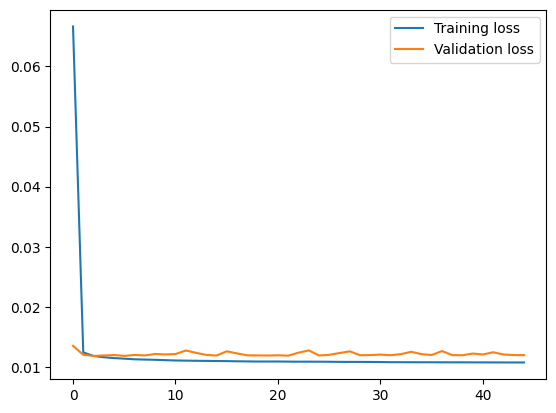

In [44]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

# Model saving

In [45]:
model.save('/content/drive/MyDrive/IMD-TP Load Forecast/ANN/RH.h5')

# Predictions

In [47]:
pred = model.predict(X_test)
pred

1045/1045 [==============================] - 3s 2ms/step


array([[0.3284257 ],
       [0.33217928],
       [0.33119065],
       ...,
       [0.6563776 ],
       [0.65248185],
       [0.6526717 ]], dtype=float32)

In [49]:
# Denormalising or Rescaling
tempy = []
for i in range(96*7 ,RH_data.shape[0]-96):
   tempy.append(RH_data[i:i+96])
tempy = np.array(tempy)
tempy=tempy.reshape(tempy.shape[0],tempy.shape[1]*tempy.shape[2])
print(tempy.shape)
scalery = MinMaxScaler()
models=scalery.fit(tempy)
sc_data=models.transform(tempy)

(133728, 96)


In [52]:
pred.shape

(33433, 1)

In [54]:
# Ensure pred has shape (33433, 96)
# pred = pred.reshape(pred.shape[0], pred.shape[1])
pred = np.reshape(pred, (pred.shape[0], 96))
pred = scalery.inverse_transform(pred)
# pred = np.reshape(pred, (pred.shape[0], 96, input.shape[2]))

ValueError: ignored